In [1]:
from PIL import Image
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader
from torchvision import transforms
from matplotlib import pyplot as plt
import inference as I
from torchvision import models
import torch.nn.functional as F

from SILog import SILogLoss
inputs = ['inputs/b10b19ef5a914d21a8d1cae75a383417-1629663559900021834.png',
          'inputs/c0bf31f67b8a41819a2044d3d9505333-1621531062300005397.png',
         'inputs/c5b940f8cea243a8acb3391e6595b8de-1643843161000015140.png']
def conv_relu_block(in_channel,out_channel,kernel,padding):
    return nn.Sequential(
            nn.Conv2d(in_channel,out_channel, kernel_size = kernel, padding=padding),
            nn.ReLU()) #nn.ReLU(inplace=True) #nn.Ge
class vanilla_unet_full(nn.Module):
    def __init__(self, n_class):
        super().__init__()
        self.input_1 = conv_relu_block(3,3,3,1) ##grayscale inputs
        #self.input_2 = conv_relu_block(64, 64, 3, 1) #no extra channels

        self.base_model = models.resnet18(pretrained=True)
        self.base_layers = list(self.base_model.children())

        self.l0 = nn.Sequential(*self.base_layers[:3])
        self.U0_conv = conv_relu_block(64, 64, 1, 0)
        self.conv_up0 = conv_relu_block(64 + 256, 128, 3, 0)

        self.l1 = nn.Sequential(*self.base_layers[3:5])
        self.U1_conv = conv_relu_block(64, 64, 1, 0)
        self.conv_up1 = conv_relu_block(64 + 256, 256, 3, 1)

        self.l2 = self.base_layers[5]
        self.U2_conv = conv_relu_block(128, 128, 1, 0)
        self.conv_up2 = conv_relu_block(128 + 512, 256, 3, 1)

        self.l3 = self.base_layers[6]
        self.U3_conv = conv_relu_block(256, 256, 1, 0)
        self.conv_up3 = conv_relu_block(256 + 512, 512, 3, 1)

        self.l4 = self.base_layers[7]
        self.U4_conv = conv_relu_block(512, 512, 1, 0)

        self.conv_up4 = conv_relu_block(64 + 128, 64, 3, 1)

        self.out4 = nn.Conv2d(128, n_class, 1)

        self.upsample = nn.Upsample(scale_factor=2, mode='bilinear', align_corners=True)

    def forward(self, x):
        x = torch.cat([x,x,x], axis = 1)
        x = self.input_1(x)
        
        #print(x.shape,'x')
         #concat on channel
        #x_one = self.input_2(x_one)
        block0 = self.l0(x)
        block1 = self.l1(block0)
        block2 = self.l2(block1)
        block3 = self.l3(block2)
        block4 = self.l4(block3)

        block4 = self.U4_conv(block4)
        #print(block4.shape)
        x = nn.Upsample(size = (138,97), mode='bilinear', align_corners=True)(block4)
        block3 = self.U3_conv(block3)
        
        x = torch.cat([x, block3], axis=1)
        x = self.conv_up3(x)
        
        x = nn.Upsample(size = (275,194), mode='bilinear', align_corners=True)(x)
        
        block2 = self.U2_conv(block2)
        
        #print(x.shape, block2.shape)
        x = torch.cat([x, block2], axis=1)
        
        x = self.conv_up2(x)

        x = nn.Upsample(size = (550,388), mode='bilinear', align_corners=True)(x)
        block1 = self.U1_conv(block1)
        #print(x.shape, block1.shape)
        
        x = torch.cat([x, block1], axis=1)
        x = self.conv_up1(x)

        x = nn.Upsample(size = (1100, 775), mode='bilinear', align_corners=True)(x) 
        block0 = self.U0_conv(block0)

        #print(x.shape, block0.shape)
        x = torch.cat([x, block0], axis=1)
        x = self.conv_up0(x)
        out4 = self.out4(x)

        #out4_upsampled = F.interpolate(out4, size=OUT_SIZE, mode='nearest', align_corners=True)
        out4_upsampled = F.interpolate(out4, size=OUT_SIZE, mode='bilinear',align_corners=True)
        
        out = out4_upsampled
        
        
        return out
class vanilla_unet_full_nearest(nn.Module):
    def __init__(self, n_class):
        super().__init__()
        self.input_1 = conv_relu_block(3,3,3,1) ##grayscale inputs
        #self.input_2 = conv_relu_block(64, 64, 3, 1) #no extra channels

        self.base_model = models.resnet18(pretrained=True)
        self.base_layers = list(self.base_model.children())

        self.l0 = nn.Sequential(*self.base_layers[:3])
        self.U0_conv = conv_relu_block(64, 64, 1, 0)
        self.conv_up0 = conv_relu_block(64 + 256, 128, 3, 0)

        self.l1 = nn.Sequential(*self.base_layers[3:5])
        self.U1_conv = conv_relu_block(64, 64, 1, 0)
        self.conv_up1 = conv_relu_block(64 + 256, 256, 3, 1)

        self.l2 = self.base_layers[5]
        self.U2_conv = conv_relu_block(128, 128, 1, 0)
        self.conv_up2 = conv_relu_block(128 + 512, 256, 3, 1)

        self.l3 = self.base_layers[6]
        self.U3_conv = conv_relu_block(256, 256, 1, 0)
        self.conv_up3 = conv_relu_block(256 + 512, 512, 3, 1)

        self.l4 = self.base_layers[7]
        self.U4_conv = conv_relu_block(512, 512, 1, 0)

        self.conv_up4 = conv_relu_block(64 + 128, 64, 3, 1)

        self.out4 = nn.Conv2d(128, n_class, 1)

        self.upsample = nn.Upsample(scale_factor=2, mode='bilinear', align_corners=True)

    def forward(self, x):
        x = torch.cat([x,x,x], axis = 1)
        x = self.input_1(x)
        
        #print(x.shape,'x')
         #concat on channel
        #x_one = self.input_2(x_one)
        block0 = self.l0(x)
        block1 = self.l1(block0)
        block2 = self.l2(block1)
        block3 = self.l3(block2)
        block4 = self.l4(block3)

        block4 = self.U4_conv(block4)
        #print(block4.shape)
        x = nn.Upsample(size = (138,97), mode='bilinear', align_corners=True)(block4)
        block3 = self.U3_conv(block3)
        
        x = torch.cat([x, block3], axis=1)
        x = self.conv_up3(x)
        
        x = nn.Upsample(size = (275,194), mode='bilinear', align_corners=True)(x)
        
        block2 = self.U2_conv(block2)
        
        #print(x.shape, block2.shape)
        x = torch.cat([x, block2], axis=1)
        
        x = self.conv_up2(x)

        x = nn.Upsample(size = (550,388), mode='bilinear', align_corners=True)(x)
        block1 = self.U1_conv(block1)
        #print(x.shape, block1.shape)
        
        x = torch.cat([x, block1], axis=1)
        x = self.conv_up1(x)

        x = nn.Upsample(size = (1100, 775), mode='bilinear', align_corners=True)(x) 
        block0 = self.U0_conv(block0)

        #print(x.shape, block0.shape)
        x = torch.cat([x, block0], axis=1)
        x = self.conv_up0(x)
        out4 = self.out4(x)

        #out4_upsampled = F.interpolate(out4, size=OUT_SIZE, mode='nearest', align_corners=True)
        out4_upsampled = F.interpolate(out4, size=OUT_SIZE, mode='nearest')
        
        out = F.relu(out4_upsampled)
        
        
        return out

/share/pkg.7/pytorch/1.13.1/install/lib/SCC/../python3.8/site-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/share/pkg.7/pytorch/1.13.1/install/lib/SCC/../python3.8/site-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet18_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet18_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


3
tensor(61.)
tensor(255, dtype=torch.int32) tensor(61, dtype=torch.int32)
tensor([[[166, 166, 166,  ..., 193, 194, 194],
         [166, 166, 166,  ..., 193, 194, 194],
         [166, 166, 166,  ..., 193, 194, 194],
         ...,
         [105, 105, 105,  ..., 184, 183, 183],
         [105, 105, 105,  ..., 183, 185, 185],
         [105, 105, 105,  ..., 183, 185, 185]]], dtype=torch.int32) tensor([[[ 89,  89,  89,  ...,  62,  61,  61],
         [ 89,  89,  89,  ...,  62,  61,  61],
         [ 89,  89,  89,  ...,  62,  61,  61],
         ...,
         [150, 150, 150,  ...,  71,  72,  72],
         [150, 150, 150,  ...,  72,  70,  70],
         [150, 150, 150,  ...,  72,  70,  70]]], dtype=torch.int32)


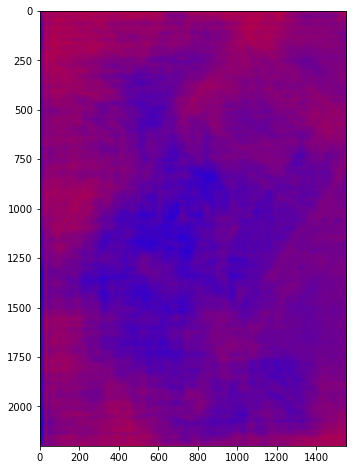

tensor(61.)
tensor(255, dtype=torch.int32) tensor(61, dtype=torch.int32)
tensor([[[156, 156, 156,  ..., 194, 192, 192],
         [156, 156, 156,  ..., 194, 192, 192],
         [156, 156, 156,  ..., 194, 192, 192],
         ...,
         [142, 142, 142,  ..., 167, 166, 166],
         [141, 141, 141,  ..., 165, 167, 167],
         [141, 141, 141,  ..., 165, 167, 167]]], dtype=torch.int32) tensor([[[ 99,  99,  99,  ...,  61,  63,  63],
         [ 99,  99,  99,  ...,  61,  63,  63],
         [ 99,  99,  99,  ...,  61,  63,  63],
         ...,
         [113, 113, 113,  ...,  88,  89,  89],
         [114, 114, 114,  ...,  90,  88,  88],
         [114, 114, 114,  ...,  90,  88,  88]]], dtype=torch.int32)


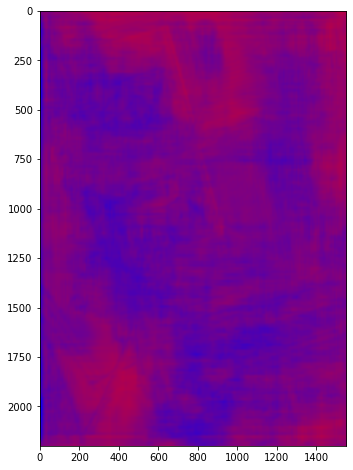

tensor(63.)
tensor(255, dtype=torch.int32) tensor(63, dtype=torch.int32)
tensor([[[153, 153, 153,  ..., 180, 177, 177],
         [153, 153, 153,  ..., 180, 177, 177],
         [153, 153, 153,  ..., 180, 177, 177],
         ...,
         [126, 126, 126,  ..., 183, 181, 181],
         [127, 127, 127,  ..., 184, 184, 184],
         [127, 127, 127,  ..., 184, 184, 184]]], dtype=torch.int32) tensor([[[102, 102, 102,  ...,  75,  78,  78],
         [102, 102, 102,  ...,  75,  78,  78],
         [102, 102, 102,  ...,  75,  78,  78],
         ...,
         [129, 129, 129,  ...,  72,  74,  74],
         [128, 128, 128,  ...,  71,  71,  71],
         [128, 128, 128,  ...,  71,  71,  71]]], dtype=torch.int32)


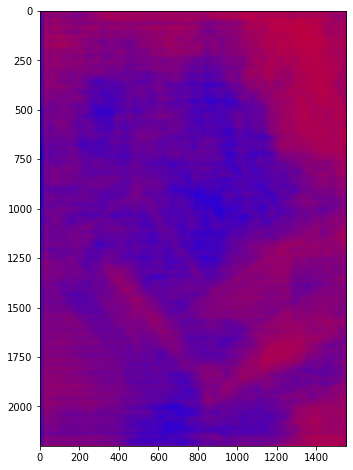

In [2]:

def display_depth_image(depth_img, scale = 1, show_image = True, target_mask = False):
    """
    makes the depth predictions into an image.
    blue is farthest away, red is closest.  
  
    depth_img is either a target or a model output.  should be 1 channel
    scale is a constant and is multiplied by the inputs.  just used to map to rgb
    show_image will print the image for convenience.  
    target_mask if it is set to true, it makes all the pixels that are exaclty zero white:
    per the competition those pixels are errors, not actual depth readings.  
    """
    b = depth_img
    rel_max = torch.max(b)
    print(torch.max(b),torch.min(b))
    g = torch.zeros_like(depth_img)
    r = rel_max - b
    print(r,b)
    pic = torch.cat((r,g,b),axis = 0)

    if target_mask:
        #for targets all 0s are invalid, make em white
        target_mask = depth_img == 0
        target_mask = target_mask.expand(-1,3,-1,-1)
        pic[target_mask] = 255
        pic = pic.squeeze().permute(1,2,0) * scale
    pic = pic.permute(1,2,0) * scale
    if show_image:
        plt.figure(figsize=(11,8))
        plt.imshow(pic)
        plt.show()
    return pic


PATH = 'unet_full_relu_nearest.pt'
OUT_SIZE = (2200, 1550)
device = torch.device("cuda")
model = vanilla_unet_full_nearest(n_class=1)
model = nn.DataParallel(model)
model.load_state_dict(torch.load(PATH, map_location="cuda:0"))
model.to(device)
transform = transforms.Compose([
    transforms.Resize(OUT_SIZE),
    transforms.ToTensor()
])
images = torch.stack([transform(Image.open(p)) for p in inputs])
images.to(device)
model.eval()
with torch.no_grad():
    out = model(images).detach().cpu()

out_vis = out.detach().cpu()
print(out_vis.shape[0])
for i in range(out_vis.shape[0]):
    print(torch.min(torch.round((out_vis[i,:,:,:]/torch.max(out_vis[i,:,:,:]))*255)))
    display_depth_image(torch.round((out_vis[i,:,:,:]/torch.max(out_vis[i,:,:,:]))*255).type(torch.int32))
